# Test case 2D-2 (unsteady)

In [1]:
from __future__ import annotations

import argparse
import csv
import os
from dataclasses import dataclass
from math import ceil, sqrt
from pathlib import Path

from netgen.geom2d import SplineGeometry
from ngsolve import (
    BilinearForm,
    CoefficientFunction,
    GridFunction,
    Grad,grad,
    H1,
    Id,
    InnerProduct,
    LinearForm,
    Integrate,
    Mesh,
    Norm,
    NumberSpace,
    SetHeapSize,
    TaskManager,
    VectorH1,
    VTKOutput,
    div,
    specialcf,
    x,
    y,
    IfPos,
    FESpace,
)
from xfem import (
    HASNEG,
    CutInfo,
    POS,
    NEG,
    IF,
    HASPOS,
    dCut,
    GetFacetsWithNeighborTypes,
    SymbolicFacetPatchBFI,
)
from xfem.lsetcurv import LevelSetMeshAdaptation
from ngsolve.solvers import Newton

try:
    import matplotlib.pyplot as plt
except ImportError:  # pragma: no cover - optional dependency
    plt = None


SetHeapSize(200 * 10**6)


@dataclass
class SimulationParameters:
    rho: float
    mu: float
    dt: float
    gamma_n: float
    gamma_gp: float
    u_max: float            # peak Poiseuille speed (DFG uses U_max = 1.5)
    diameter: float
    p_reg: float = 1.0e-8
    order: int = 2
    dt_cfl: float | None = None

    @property
    def u_mean(self) -> float:
        """Mean channel velocity corresponding to the parabolic profile.

        For u(y) = 4 U_max * y (H - y) / H^2, the mean is (2/3) U_max.
        """
        return 2.0 * self.u_max / 3.0


def parabolic_inflow(height: float, u_max: float) -> CoefficientFunction:
    """Return the DFG parabolic inflow profile."""
    return CoefficientFunction((4.0 * u_max * y * (height - y) / (height ** 2), 0.0))


def build_background_mesh(length: float, height: float, maxh: float, 
                          split_x: float = 0.7, refine_factor: float = 6.0) -> Mesh:
    """
    Generate a background mesh, split into two domains
    for refinement (e.g., for Turek benchmark).

    - Domain 1 (Left, refined): 0 < x < split_x
    - Domain 2 (Right, coarse): split_x < x < length
    """
    geo = SplineGeometry()

    # Define the 6 corner points for the two-domain layout
    # This matches the topology of your second example:
    # p1=(0,0), p2=(split_x,0), p3=(length,0)
    # p4=(length,height), p5=(split_x,height), p6=(0,height)
    p1 = geo.AddPoint(0.0, 0.0)
    p2 = geo.AddPoint(split_x, 0.0)
    p3 = geo.AddPoint(length, 0.0)
    p4 = geo.AddPoint(length, height)
    p5 = geo.AddPoint(split_x, height)
    p6 = geo.AddPoint(0.0, height)

    # --- Define boundaries and domains ---
    # Domain 1 (Left box, will be refined)
    geo.Append (["line", p1, p2], leftdomain=1, rightdomain=0, bc="wall")  # Bottom-left
    geo.Append (["line", p2, p5], leftdomain=1, rightdomain=2)            # --- Internal Interface ---
    geo.Append (["line", p5, p6], leftdomain=1, rightdomain=0, bc="wall")  # Top-left
    geo.Append (["line", p6, p1], leftdomain=1, rightdomain=0, bc="inlet") # Left wall (inlet)

    # Domain 2 (Right box, coarse)
    geo.Append (["line", p2, p3], leftdomain=2, rightdomain=0, bc="wall")   # Bottom-right
    geo.Append (["line", p3, p4], leftdomain=2, rightdomain=0, bc="outlet") # Right wall (outlet)
    geo.Append (["line", p4, p5], leftdomain=2, rightdomain=0, bc="wall")   # Top-right

    # Set domain-specific mesh sizes
    # Domain 1 (left, where cylinder will be) gets the fine mesh
    geo.SetDomainMaxH(1, maxh / refine_factor)
    # Domain 2 (right, far field) gets the coarse mesh
    geo.SetDomainMaxH(2, maxh)

    # Generate mesh
    mesh = Mesh(geo.GenerateMesh(maxh=maxh, quad_dominated=False))
    mesh.Curve(3)
    return mesh


def levelset_for_cylinder(cx: float, cy: float, radius: float) -> CoefficientFunction:
    """Signed distance to the circular obstacle (positive outside)."""
    return Norm(CoefficientFunction((x - cx, y - cy))) - radius


def symgrad(v):
    """Return the symmetric gradient tensor."""
    grad_v = Grad(v)
    return 0.5 * (grad_v + grad_v.trans)


def divergence(v):
    grad_v = Grad(v)
    dim = grad_v.dims[0]
    return sum(grad_v[i, i] for i in range(dim))


def setup_cut_geometry(mesh: Mesh, levelset_cf: CoefficientFunction, order: int):
    """Create the isoparametric deformation and CutInfo for the level-set."""
    lset_adapter = LevelSetMeshAdaptation(
        mesh,
        order=max(2, order),
        threshold=10.5,
        discontinuous_qn=True,
    )
    deformation = lset_adapter.CalcDeformation(levelset_cf)
    mesh.deformation = deformation
    lset_p1 = lset_adapter.lset_p1
    cut_info = CutInfo(mesh, lset_p1)
    return lset_p1, deformation, cut_info

from xfem import  GetDofsOfElements
from ngsolve import Compress
def build_cut_spaces(mesh: Mesh, _cut_info: CutInfo, order: int):
    """Taylor-Hood spaces on the background mesh with jump couplings enabled."""
    Vh = VectorH1(mesh, order=order, dirichlet="inlet|wall", dgjumps=True)
    Qh = H1(mesh, order=max(1, order - 1), dgjumps=True)
    VhG = Compress(Vh,GetDofsOfElements(Vh,_cut_info.GetElementsOfType(HASPOS))) 
    QhG = Compress(Qh,GetDofsOfElements(Qh,_cut_info.GetElementsOfType(HASPOS)))

    return FESpace([VhG, QhG], dgjumps=True)


def build_measures(mesh: Mesh, cut_info: CutInfo, lset_p1, deformation):
    """Return volume, interface and ghost facet sets."""
    els_outer = cut_info.GetElementsOfType(HASPOS)
    els_inner = cut_info.GetElementsOfType(HASNEG)
    dx_fluid = dCut(levelset=lset_p1, domain_type=POS, 
                    deformation=deformation,
                    definedonelements=els_outer)
    dx_inside = dCut(levelset=lset_p1, domain_type=NEG, deformation=deformation, definedonelements=els_inner)
    ds_interface = dCut(levelset=lset_p1, domain_type=IF, deformation=deformation)

    positive_elements = cut_info.GetElementsOfType(HASPOS)
    interface_elements = cut_info.GetElementsOfType(IF)
    ghost_facets = GetFacetsWithNeighborTypes(mesh, a=positive_elements, b=interface_elements,
                                              use_and=True)
    return dx_fluid, ds_interface, ghost_facets, dx_inside





def compute_forces(
    mesh: Mesh,
    velocity: GridFunction,
    pressure: GridFunction,
    params: SimulationParameters,
    ds_interface,
    normal_cf,
):
    """Return drag, lift and their dimensionless coefficients."""
    vel_cf = CoefficientFunction(velocity)
    press_cf = CoefficientFunction(pressure)

    traction = (2.0 * params.mu * symgrad(vel_cf) - press_cf * Id(mesh.dim)) * normal_cf
    ex = CoefficientFunction((1.0, 0.0))
    ey = CoefficientFunction((0.0, 1.0))
    drag = Integrate(InnerProduct(traction, ex) * ds_interface, mesh=mesh)
    lift = -Integrate(InnerProduct(traction, ey) * ds_interface, mesh=mesh)
    Uref = params.u_mean  # = 2/3 * u_max
    coeff = 2.0 / (params.rho * (Uref ** 2) * params.diameter)
    return float(drag), float(lift), float(coeff * drag), float(coeff * lift)


def compute_pressure_drop(pressure: GridFunction, point_a, point_b) -> float:
    """Evaluate Δp between two probe points (A minus B)."""
    pa = pressure(point_a[0], point_a[1])
    pb = pressure(point_b[0], point_b[1])
    return float(pa - pb)
def plotting(times, drag_hist, lift_hist, cd_hist, cl_hist, dp_hist):
    # Create a 3x2 grid of subplots.
    # `sharex=True` links the x-axes of all plots.
    # `figsize` is adjusted for a wider layout.
    fig, axes = plt.subplots(3, 2, figsize=(12, 9), sharex=True)
    
    # --- Row 0: Coefficients ---
    # Subplot (0, 0) for Drag Coefficient
    axes[0, 0].plot(times, cd_hist, label="Cd", color="blue")
    axes[0, 0].set_ylabel("Drag Coefficient (Cd)")
    axes[0, 0].grid(True, linestyle=":", linewidth=0.5)
    axes[0, 0].set_title("Drag Coefficient over Time")

    # Subplot (0, 1) for Lift Coefficient
    axes[0, 1].plot(times, cl_hist, label="Cl", color="green")
    axes[0, 1].set_ylabel("Lift Coefficient (Cl)")
    axes[0, 1].grid(True, linestyle=":", linewidth=0.5)
    axes[0, 1].set_title("Lift Coefficient over Time")

    # --- Row 1: Forces ---
    # Subplot (1, 0) for Drag Force
    axes[1, 0].plot(times, drag_hist, label="Drag", color="red")
    axes[1, 0].set_ylabel("Drag Force")
    axes[1, 0].grid(True, linestyle=":", linewidth=0.5)
    axes[1, 0].set_title("Drag Force over Time")

    # Subplot (1, 1) for Lift Force
    axes[1, 1].plot(times, lift_hist, label="Lift", color="purple")
    axes[1, 1].set_ylabel("Lift Force")
    axes[1, 1].grid(True, linestyle=":", linewidth=0.5)
    axes[1, 1].set_title("Lift Force over Time")

    # --- Row 2: Pressure Drop ---
    # Subplot (2, 0) for Pressure Drop
    axes[2, 0].plot(times, dp_hist, label="Δp", color="orange")
    axes[2, 0].set_xlabel("Time")
    axes[2, 0].set_ylabel("Pressure Drop (Δp)")
    axes[2, 0].grid(True, linestyle=":", linewidth=0.5)
    axes[2, 0].set_title("Pressure Drop over Time")

    # Subplot (2, 1) is unused, so we turn it off
    fig.delaxes(axes[2, 1])

    # Add a main title to the entire figure
    fig.suptitle("Flow Diagnostics for Turek Benchmark", fontsize=16)

    # Adjust layout to prevent titles and labels from overlapping
    fig.tight_layout(rect=[0, 0, 1, 0.96]) # rect leaves space for suptitle
    plt.show()


importing ngsxfem-2.1.2501.dev0


In [2]:
def build_nonlinear_form(
    space,
    params: SimulationParameters,
    measures,
    lset_p1,
    previous_velocity: GridFunction,
):
    """Create the semilinear form defining the Navier–Stokes residual."""
    dx_fluid, ds_interface, ghost_facets, dx_inside = measures
    (u, p), (v, q) = space.TnT()

    vel_prev_cf = CoefficientFunction(previous_velocity)
    normal_vec = 1.0 / Norm(Grad(lset_p1)) * Grad(lset_p1)
    h = specialcf.mesh_size

    form = BilinearForm(space, check_unused=False)
    form += params.rho / params.dt * InnerProduct(u - vel_prev_cf, v) * dx_fluid
    form += params.rho * InnerProduct(Grad(u) * u, v) * dx_fluid
    form += params.mu * InnerProduct(grad(u), grad(v)) * dx_fluid
    form += -p * div(v) * dx_fluid
    form += q * divergence(u) * dx_fluid


    Gamma_penalty = params.gamma_n * (params.order * params.order) * params.mu / h
    form += (
        - params.mu * InnerProduct(grad(u) * normal_vec, v)
        - params.mu * InnerProduct(grad(v) * normal_vec, u)
        + Gamma_penalty * InnerProduct(u, v)
        + p * InnerProduct(v, normal_vec)
        - q * InnerProduct(u, normal_vec)
    ) * ds_interface

    if params.gamma_gp > 0.0:
        ghost_integrand = params.gamma_gp * params.mu / h ** 2 * InnerProduct(
            u - u.Other(), v - v.Other()
        )
        ghost_integrand += -params.gamma_gp / params.mu * (p - p.Other()) * (
            q - q.Other()
        )
        form += SymbolicFacetPatchBFI(
            form=ghost_integrand,
            skeleton=False,
            definedonelements=ghost_facets,
        )

    return form


def build_picard_forms(
    space,
    params: SimulationParameters,
    measures,
    lset_p1,
    previous_velocity: GridFunction,
    convection_velocity: GridFunction,
):
    """
    Build the bilinear and linear forms used for Richardson/Picard iterations.

    The convection velocity is frozen to ``convection_velocity`` so that the
    resulting system is linear in the unknown ``space`` components.
    """
    dx_fluid, ds_interface, ghost_facets, dx_inside = measures
    (u, p), (v, q) = space.TnT()

    vel_prev_cf = CoefficientFunction(previous_velocity)
    conv_cf = CoefficientFunction(convection_velocity)
    normal_vec = 1.0 / Norm(Grad(lset_p1)) * Grad(lset_p1)
    h = specialcf.mesh_size

    bilinear = BilinearForm(space, symmetric=False, check_unused=False)
    bilinear += params.rho / params.dt * InnerProduct(u, v) * dx_fluid
    bilinear += params.rho * InnerProduct(Grad(u) * conv_cf, v) * dx_fluid
    bilinear += params.mu * InnerProduct(grad(u), grad(v)) * dx_fluid
    bilinear += -p * div(v) * dx_fluid
    bilinear += q * divergence(u) * dx_fluid

    Gamma_penalty = params.gamma_n * (params.order * params.order) * params.mu / h
    bilinear += (
        -params.mu * InnerProduct(grad(u) * normal_vec, v)
        -params.mu * InnerProduct(grad(v) * normal_vec, u)
        + Gamma_penalty * InnerProduct(u, v)
        + p * InnerProduct(v, normal_vec)
        - q * InnerProduct(u, normal_vec)
    ) * ds_interface

    if params.p_reg > 0.0:
        bilinear += params.p_reg * p * q * dx_fluid

    if params.gamma_gp > 0.0:
        ghost_integrand = params.gamma_gp * params.mu / h**2 * InnerProduct(
            u - u.Other(), v - v.Other()
        )
        ghost_integrand += -params.gamma_gp / params.mu * (p - p.Other()) * (
            q - q.Other()
        )
        bilinear += SymbolicFacetPatchBFI(
            form=ghost_integrand,
            skeleton=False,
            definedonelements=ghost_facets,
        )

    rhs = LinearForm(space)
    rhs += params.rho / params.dt * InnerProduct(vel_prev_cf, v) * dx_fluid

    return bilinear, rhs


def build_sbdf_bilinear_form(
    space,
    params: SimulationParameters,
    measures,
    lset_p1,
    mass_coefficient: float,
):
    """
    Build the bilinear form for the SBDF IMEX time step.

    The velocity mass term is weighted with ``mass_coefficient``; diffusion and
    pressure contributions match the CutFEM discretisation used elsewhere.
    """
    dx_fluid, ds_interface, ghost_facets, _ = measures
    (u, p), (v, q) = space.TnT()

    normal_vec = 1.0 / Norm(Grad(lset_p1)) * Grad(lset_p1)
    h = specialcf.mesh_size

    form = BilinearForm(space, symmetric=False, check_unused=False)
    form += mass_coefficient * InnerProduct(u, v) * dx_fluid
    form += params.mu * InnerProduct(grad(u), grad(v)) * dx_fluid
    form += -p * div(v) * dx_fluid
    form += q * divergence(u) * dx_fluid

    Gamma_penalty = params.gamma_n * (params.order * params.order) * params.mu / h
    form += (
        -params.mu * InnerProduct(grad(u) * normal_vec, v)
        -params.mu * InnerProduct(grad(v) * normal_vec, u)
        + Gamma_penalty * InnerProduct(u, v)
        + p * InnerProduct(v, normal_vec)
        - q * InnerProduct(u, normal_vec)
    ) * ds_interface

    if params.p_reg > 0.0:
        form += params.p_reg * p * q * dx_fluid

    if params.gamma_gp > 0.0:
        ghost_integrand = params.gamma_gp * params.mu / h**2 * InnerProduct(
            u - u.Other(), v - v.Other()
        )
        ghost_integrand += -params.gamma_gp / params.mu * (p - p.Other()) * (
            q - q.Other()
        )
        form += SymbolicFacetPatchBFI(
            form=ghost_integrand,
            skeleton=False,
            definedonelements=ghost_facets,
        )

    return form


def assemble_sbdf_rhs(
    space,
    params: SimulationParameters,
    measures,
    velocity_prev: GridFunction,
    velocity_prev2: GridFunction | None,
    step_index: int,
):
    """
    Assemble the right-hand side for the SBDF IMEX step.

    The convective term is extrapolated explicitly: SBDF1 for the first step,
    SBDF2 afterwards according to 2 f(u^n) - f(u^{n-1}).
    """
    dx_fluid, *_ = measures
    (_, _), (v, _) = space.TnT()

    vel_prev_cf = CoefficientFunction(velocity_prev)
    rhs = LinearForm(space)

    conv_prev = InnerProduct(Grad(vel_prev_cf) * vel_prev_cf, v)

    if step_index == 1 or velocity_prev2 is None:
        rhs += params.rho / params.dt * InnerProduct(vel_prev_cf, v) * dx_fluid
        rhs += -params.rho * conv_prev * dx_fluid
    else:
        vel_prev2_cf = CoefficientFunction(velocity_prev2)
        conv_prev2 = InnerProduct(Grad(vel_prev2_cf) * vel_prev2_cf, v)
        rhs += (
            params.rho
            / (2.0 * params.dt)
            * InnerProduct(4.0 * vel_prev_cf - vel_prev2_cf, v)
            * dx_fluid
        )
        rhs += -params.rho * (2.0 * conv_prev - conv_prev2) * dx_fluid

    return rhs


In [3]:
# --- Simulation Parameters ---
dt = 0.01                # time step size
tend = 0.5               # final simulation time
num_steps = None         # override the number of time steps (None means use dt and tend)
order = 2                # velocity polynomial order
maxh = 0.05              # background mesh size
refine_factor_left = 6.0 # refinement factor in the inlet region (matches reference SBDF setup)

# --- Physical Properties ---
rho = 1.0                # density
mu = 1.0e-3              # dynamic viscosity
u_max = 1.0             # max inflow velocity

# --- Numerical/Solver Parameters ---
gamma_n = 40.0           # Nitsche penalty
gamma_gp = 1e-2          # ghost penalty coefficient
newton_tol = 1.0e-8      # Newton residual tolerance
newton_max_it = 15       # maximum Newton iterations
newton_damp = 1.0        # Newton damping factor
quiet_newton = False     # suppress Newton iteration output (set to True to suppress)

# --- Solver switching ---
solver_type = "sbdf"     # choose between "newton", "richardson", or "sbdf"
richardson_tol = 1.0e-8  # residual tolerance for Richardson/Picard iterations
richardson_max_it = 8    # maximum Richardson/Picard iterations per time step
richardson_damp = 1.0    # damping applied to Richardson updates
richardson_solver = "umfpack"  # linear solver used for Richardson updates
richardson_verbose = False     # print Richardson iteration history
sbdf_solver = "sparsecholesky" # linear solver for SBDF steps
sbdf_residual_tol = None       # set to a float to enforce a relative residual tolerance
sbdf_verbose = False           # print SBDF residual information
sbdf_cfl_number = 0.45         # CFL number used to cap the SBDF time step

# --- I/O ---
output_dir = Path("turek_ngsolve_results") # Output directory

# --- Testing overrides ---
test_flag = os.getenv("PYCUTFEM_SBDF_TEST", "").lower()
if test_flag in {"1", "true", "yes"}:
    dt = float(os.getenv("PYCUTFEM_SBDF_TEST_DT", str(dt)))
    num_steps = int(os.getenv("PYCUTFEM_SBDF_TEST_STEPS", "3"))
    solver_type = os.getenv("PYCUTFEM_SBDF_TEST_SOLVER", solver_type)
    quiet_newton = True
    cfl_override = os.getenv("PYCUTFEM_SBDF_TEST_CFL")
    if cfl_override:
        sbdf_cfl_number = float(cfl_override)

sbdf_dt_cfl = None
if solver_type.lower() == "sbdf":
    effective_h = maxh / refine_factor_left
    if u_max > 0.0:
        sbdf_dt_cfl = sbdf_cfl_number * effective_h / u_max
        if sbdf_dt_cfl > 0.0:
            dt = min(dt, sbdf_dt_cfl)


In [4]:
import re
from ngsolve.webgui import Draw
from xfem import DrawDC
params = SimulationParameters(
    rho=rho,
    mu=mu,
    dt=dt,
    gamma_n=gamma_n,
    gamma_gp=gamma_gp,
    u_max=u_max,
    diameter=0.1,
    order=order,
    dt_cfl=sbdf_dt_cfl,
)

num_steps = num_steps or max(1, ceil(tend / dt))

length, height = 2.2, 0.41
mesh = build_background_mesh(length, height, maxh, refine_factor=refine_factor_left)

if params.dt_cfl is not None:
    print(
        f"SBDF CFL-controlled dt: {params.dt_cfl:.4e}; "
        f"applied time step: {params.dt:.4e}"
    )

levelset_cf = levelset_for_cylinder(0.2, 0.2, params.diameter * 0.5)
lset_p1, deformation, cut_info = setup_cut_geometry(mesh, levelset_cf, order)
space = build_cut_spaces(mesh, cut_info, order)
measures = build_measures(mesh, cut_info, lset_p1, deformation)

gfu = GridFunction(space, name="state")
velocity, pressure = gfu.components
initial_profile = parabolic_inflow(height, params.u_mean)
# initial_field = IfPos(lset_p1, initial_profile, CoefficientFunction((0.0, 0.0)))
velocity.Set(initial_profile, definedon=mesh.Boundaries("inlet"))
pressure.Set(0.0)
Draw(mesh)


SBDF CFL-controlled dt: 3.7500e-03; applied time step: 3.7500e-03


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [5]:
from ngsolve import Normalize
inflow_profile = parabolic_inflow(height, params.u_mean)
velocity.Set(inflow_profile, definedon=mesh.Boundaries("inlet"))
previous_velocity = GridFunction(space.components[0])
previous_velocity.vec.data = velocity.vec
previous_velocity2 = GridFunction(space.components[0])
previous_velocity2.vec.data = velocity.vec
sbdf_form = None
sbdf_rhs = None

solver_type_lower = solver_type.lower()
if solver_type_lower == "newton":
    nonlinear_form = build_nonlinear_form(
        space, params, measures, lset_p1, previous_velocity
    )
    picard_form = None
    picard_rhs = None
    convection_velocity = None
elif solver_type_lower == "richardson":
    convection_velocity = GridFunction(space.components[0], name="convection_velocity")
    convection_velocity.vec.data = velocity.vec
    picard_form, picard_rhs = build_picard_forms(
        space,
        params,
        measures,
        lset_p1,
        previous_velocity,
        convection_velocity,
    )
    nonlinear_form = None
elif solver_type_lower == "sbdf":
    nonlinear_form = None
    picard_form = None
    picard_rhs = None
    convection_velocity = None
    sbdf_form = None
    sbdf_rhs = None
else:
    raise ValueError(
        f"Unknown solver_type '{solver_type}'. Use 'newton', 'richardson', or 'sbdf'."
    )

freedofs = space.FreeDofs()
normal_cf = Normalize(grad(lset_p1))

Draw(velocity, mesh, "velocity")


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

--- Starting CutFEM Turek benchmark (NGSolve/ngsxfem) ---

Step 001/134 | t = 0.004
  Drag=-1.5092e-05, Lift=-1.4265e-06, Cd=-0.0007, Cl=-0.0001, Δp=-2.3617e-04

Step 002/134 | t = 0.007
  Drag=-2.2391e-05, Lift=-2.1279e-06, Cd=-0.0010, Cl=-0.0001, Δp=-3.4567e-04

Step 003/134 | t = 0.011
  Drag=-4.4800e-05, Lift=-4.2556e-06, Cd=-0.0020, Cl=-0.0002, Δp=-6.9098e-04

Step 004/134 | t = 0.015
  Drag=-8.9637e-05, Lift=-8.5119e-06, Cd=-0.0040, Cl=-0.0004, Δp=-1.3815e-03

Step 005/134 | t = 0.019
  Drag=-1.7933e-04, Lift=-1.7025e-05, Cd=-0.0081, Cl=-0.0008, Δp=-2.7626e-03

Step 006/134 | t = 0.022
  Drag=-3.5877e-04, Lift=-3.4053e-05, Cd=-0.0161, Cl=-0.0015, Δp=-5.5248e-03

Step 007/134 | t = 0.026
  Drag=-7.1771e-04, Lift=-6.8111e-05, Cd=-0.0323, Cl=-0.0031, Δp=-1.1050e-02

Step 008/134 | t = 0.030
  Drag=-1.4357e-03, Lift=-1.3623e-04, Cd=-0.0646, Cl=-0.0061, Δp=-2.2101e-02

Step 009/134 | t = 0.034
  Drag=-2.8720e-03, Lift=-2.7247e-04, Cd=-0.1292, Cl=-0.0123, Δp=-4.4205e-02

Step 010/134 |

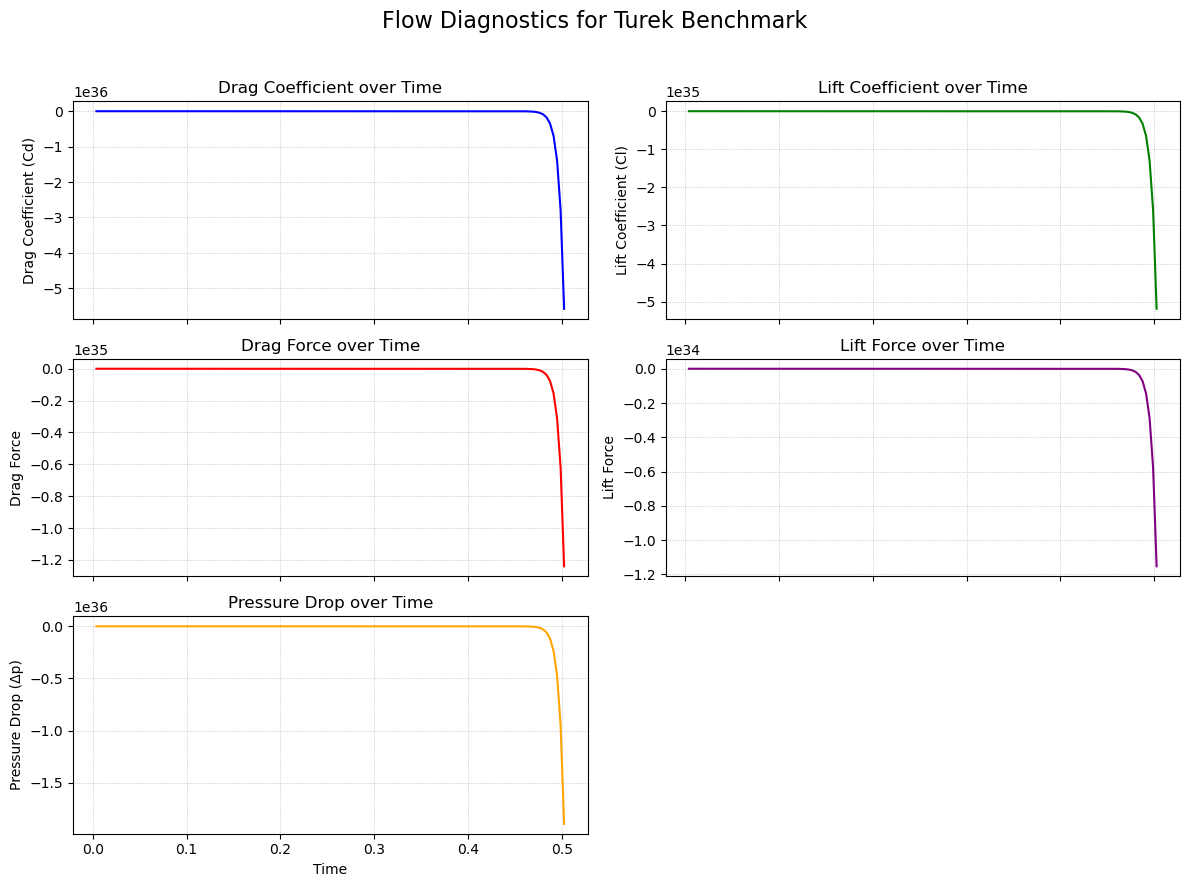

In [6]:
output_dir.mkdir(parents=True, exist_ok=True)
forces_path = output_dir / "forces.csv"
pressure_path = output_dir / "pressure_drop.csv"

velocity_cf = CoefficientFunction(velocity)
velocity_mag = Norm(velocity_cf)

vtk_output = VTKOutput(
    mesh,
    coefs=[velocity, pressure, velocity_mag],
    names=["velocity", "pressure", "velocity_magnitude"],
    filename=str((output_dir / "turek_ngsolve").resolve()),
    subdivision=2,
)
scene_u = DrawDC(velocity,-1,1, mesh, "velocity")

solver_type_lower = solver_type.lower()

times: list[float] = []
drag_hist: list[float] = []
lift_hist: list[float] = []
cd_hist: list[float] = []
cl_hist: list[float] = []
dp_hist: list[float] = []

with forces_path.open("w", newline="") as f_forces, pressure_path.open("w", newline="") as f_press:
    forces_writer = csv.writer(f_forces)
    pressure_writer = csv.writer(f_press)
    forces_writer.writerow(["step", "time", "drag", "lift", "cd", "cl"])
    pressure_writer.writerow(["step", "time", "delta_p"])

    current_time = 0.0
    print("--- Starting CutFEM Turek benchmark (NGSolve/ngsxfem) ---")
    for step in range(1, num_steps + 1):
        current_time += params.dt
        print(f"\nStep {step:03d}/{num_steps:03d} | t = {current_time:.3f}")

        velocity.Set(inflow_profile, definedon=mesh.Boundaries("inlet"))
        velocity.Set((0.0, 0.0), definedon=mesh.Boundaries("wall"))

        if solver_type_lower == "newton":
            status, iters = Newton(
                nonlinear_form,
                gfu,
                freedofs=freedofs,
                maxit=newton_max_it,
                maxerr=newton_tol,
                dampfactor=newton_damp,
                printing=not quiet_newton,
            )
            if status != 0:
                raise ValueError(
                    "  Warning: Newton did not converge within the allotted iterations."
                )
            elif not quiet_newton:
                print(f"  Newton converged in {iters} iterations.")
        elif solver_type_lower == "richardson":
            picard_rhs.Assemble()
            convection_velocity.vec.data = previous_velocity.vec
            rhs_norm = picard_rhs.vec.Norm()
            rhs_norm = rhs_norm if rhs_norm > 0.0 else 1.0
            converged = False
            last_rel_res = None

            for it in range(1, richardson_max_it + 1):
                with TaskManager():
                    picard_form.Assemble()

                residual_vec = picard_rhs.vec.CreateVector()
                residual_vec.data = picard_rhs.vec
                residual_vec.data -= picard_form.mat * gfu.vec

                abs_res = residual_vec.Norm()
                last_rel_res = abs_res / rhs_norm
                if richardson_verbose:
                    print(
                        f"  Richardson iter {it:02d}: ||r|| = {abs_res:.3e} "
                        f"(rel {last_rel_res:.3e})"
                    )

                if last_rel_res < richardson_tol:
                    converged = True
                    break

                solver = picard_form.mat.Inverse(
                    freedofs, inverse=richardson_solver
                )
                delta = solver * residual_vec
                gfu.vec.data += richardson_damp * delta

                velocity.Set(inflow_profile, definedon=mesh.Boundaries("inlet"))
                velocity.Set((0.0, 0.0), definedon=mesh.Boundaries("wall"))
                convection_velocity.vec.data = velocity.vec

            if not converged:
                raise ValueError(
                    "Richardson iteration did not converge within the allotted iterations."
                )
            if not richardson_verbose:
                print(
                    f"  Richardson converged in {it} iterations "
                    f"(rel ||r|| = {last_rel_res:.3e})"
                )
        elif solver_type_lower == "sbdf":
            mass_coeff = (
                params.rho / params.dt
                if step == 1
                else 3.0 * params.rho / (2.0 * params.dt)
            )
            sbdf_form = build_sbdf_bilinear_form(
                space, params, measures, lset_p1, mass_coeff
            )
            sbdf_rhs = assemble_sbdf_rhs(
                space,
                params,
                measures,
                previous_velocity,
                previous_velocity2 if step > 1 else None,
                step,
            )

            with TaskManager():
                sbdf_form.Assemble()
            with TaskManager():
                sbdf_rhs.Assemble()
            rhs_norm = sbdf_rhs.vec.Norm()
            rhs_norm = rhs_norm if rhs_norm > 0.0 else 1.0

            residual_vec = sbdf_rhs.vec.CreateVector()
            residual_vec.data = sbdf_rhs.vec
            residual_vec.data -= sbdf_form.mat * gfu.vec

            solver = sbdf_form.mat.Inverse(freedofs, inverse=sbdf_solver)
            delta = solver * residual_vec
            gfu.vec.data += delta

            velocity.Set(inflow_profile, definedon=mesh.Boundaries("inlet"))
            velocity.Set((0.0, 0.0), definedon=mesh.Boundaries("wall"))

            post_residual = sbdf_rhs.vec.CreateVector()
            post_residual.data = sbdf_rhs.vec
            post_residual.data -= sbdf_form.mat * gfu.vec
            post_norm = post_residual.Norm()
            rel_res = post_norm / rhs_norm
            if sbdf_verbose:
                print(
                    f"  SBDF residual after solve: abs={post_norm:.3e}, rel={rel_res:.3e}"
                )
            if sbdf_residual_tol is not None and rel_res > sbdf_residual_tol:
                raise ValueError(
                    f"SBDF linear solve residual {rel_res:.3e} "
                    f"exceeds tolerance {sbdf_residual_tol:.3e}"
                )
        else:
            raise RuntimeError(f"Unsupported solver_type '{solver_type}'.")

        drag, lift, cd, cl = compute_forces(
            mesh,
            velocity,
            pressure,
            params,
            measures[1],
            normal_cf,
        )
        delta_p = compute_pressure_drop(pressure, (0.15, 0.2), (0.25, 0.2))

        print(f"  Drag={drag:.4e}, Lift={lift:.4e}, Cd={cd:.4f}, Cl={cl:.4f}, Δp={delta_p:.4e}")
        forces_writer.writerow([step, current_time, drag, lift, cd, cl])
        pressure_writer.writerow([step, current_time, delta_p])
        f_forces.flush()
        f_press.flush()

        times.append(current_time)
        drag_hist.append(drag)
        lift_hist.append(lift)
        cd_hist.append(cd)
        cl_hist.append(cl)
        dp_hist.append(delta_p)

        vtk_output.Do(time=current_time)

        if solver_type_lower == "sbdf":
            previous_velocity2.vec.data = previous_velocity.vec
        previous_velocity.vec.data = velocity.vec
        if convection_velocity is not None:
            convection_velocity.vec.data = velocity.vec
        scene_u.Redraw()

print("\nSimulation finished.")

if plt is not None and times:
    plotting(times, drag_hist, lift_hist, cd_hist, cl_hist, dp_hist)
elif plt is None:
    print("Matplotlib not available; skipped diagnostic plot.")
